Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

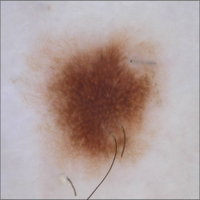

In [5]:
#checking a image from the dataset
nevus_eg = list(data_dir_train.glob('nevus/*'))
im=PIL.Image.open(str(nevus_eg[20]))
image = im.resize((200, 200))
image

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

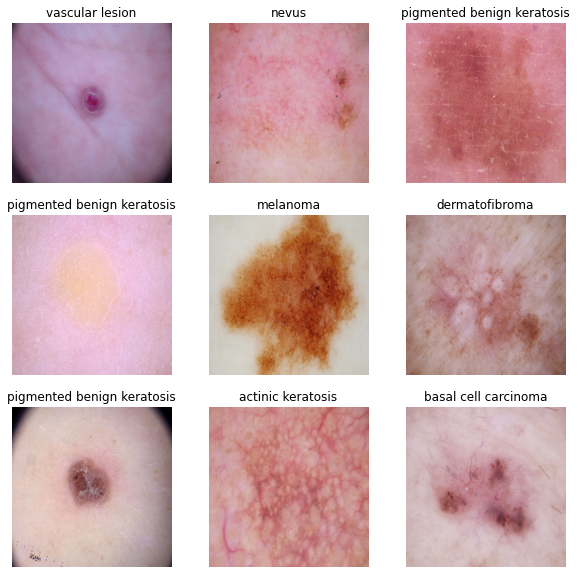

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Normalizing the pixels
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(
    scale=1./255,input_shape=(img_height, img_width, 3))

In [13]:
num_classes = len(class_names)

In [14]:
model = Sequential([
  normalization_layer,
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 168s 578ms/step - loss: 2.0533 - accuracy: 0.2054 - val_loss: 1.9527 - val_accuracy: 0.2394
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.8384 - accuracy: 0.3086 - val_loss: 1.9171 - val_accuracy: 0.2483
Epoch 3/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6976 - accuracy: 0.3761 - val_loss: 1.6530 - val_accuracy: 0.3915
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6113 - accuracy: 0.4129 - val_loss: 1.6225 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4713 - accuracy: 0.4732 - val_loss: 1.4223 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3568 - accuracy: 0.5273 - val_loss: 1.4223 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3556 - accuracy: 0.5190 - val_loss: 1.5015 - val_accuracy: 0.5168
Epoch 8/20

### Visualizing training results

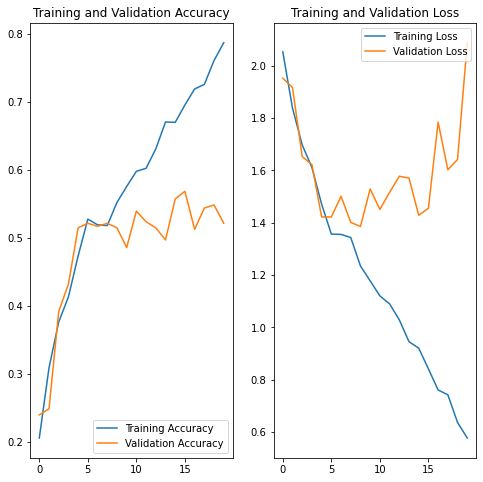

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The training accuracy is over 78% but the validation accuracy is 52.13%
Similarly, the training loss is 0.56 while the validation loss is 2.089
The above graph also shows the same trend with Training Loss continuously reduces, but the Validation Loss starts increasing after a few epochs.
The Model is overfitting the data

### Write your findings here

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
  ]
)

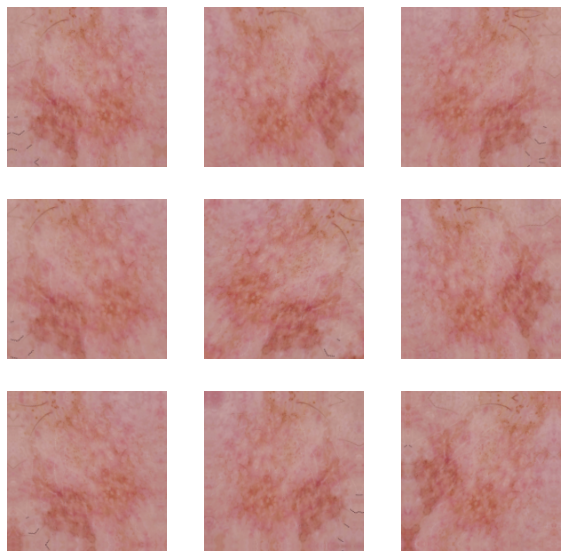

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 33ms/step - loss: 1.9423 - accuracy: 0.2879 - val_loss: 1.7302 - val_accuracy: 0.3557
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6957 - accuracy: 0.3867 - val_loss: 1.6091 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5721 - accuracy: 0.4275 - val_loss: 1.5313 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5608 - accuracy: 0.4358 - val_loss: 1.5298 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5119 - accuracy: 0.4481 - val_loss: 1.4218 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4379 - accuracy: 0.4827 - val_loss: 1.5002 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3952 - accuracy: 0.4972 - val_loss: 1.3246 - val_accuracy: 0.5391
Epoch 8/20
56

### Visualizing the results

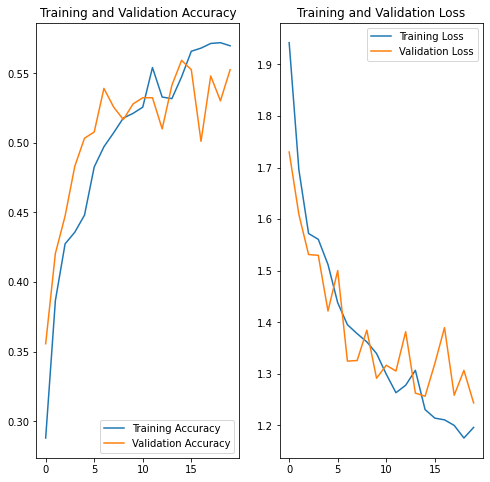

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The model is not as overfitted as previous one.But we have some over fitting 
where as the training- loss: 1.1960 - accuracy: 0.5698 the value  val_loss: 1.2435 - val_accuracy: 0.5526 all are reduced.

This model is better than previous one but still low accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

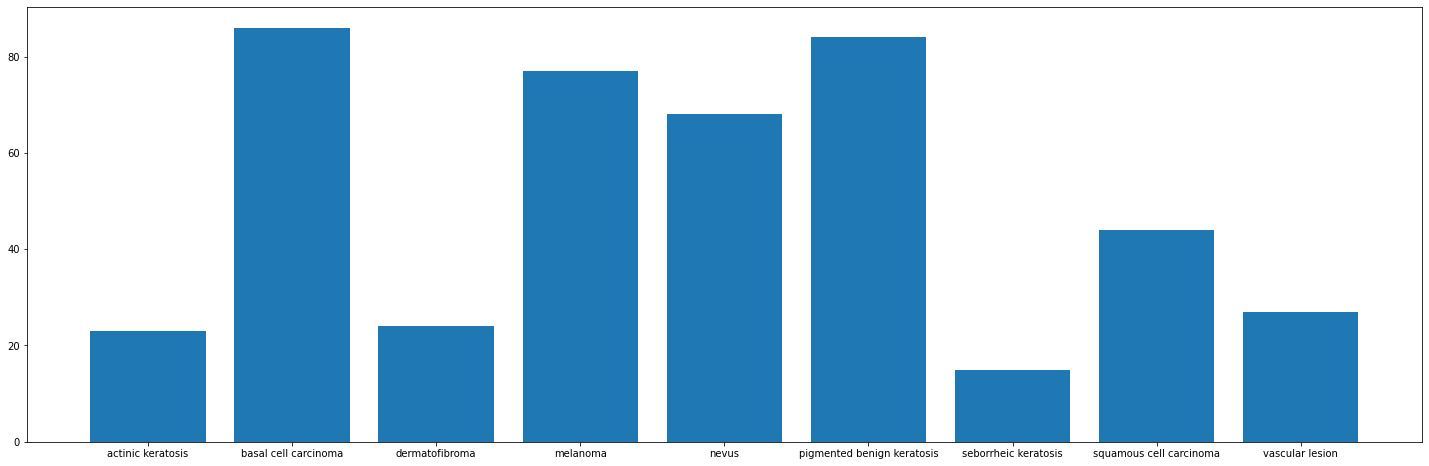

In [26]:
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(8):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure(figsize=(25,8))

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
        'seborrheic keratosis' has least samples
#### - Which classes dominate the data in terms proportionate number of samples?
        pigmented benign keratosis' has high nuber of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [29]:
path_to_training_dataset='/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1111C0AE10>: 100%|██████████| 500/500 [00:21<00:00, 23.42 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1111C0A950>: 100%|██████████| 500/500 [00:24<00:00, 20.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1111B04310>: 100%|██████████| 500/500 [00:26<00:00, 18.87 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1111BF5B90>: 100%|██████████| 500/500 [01:31<00:00,  5.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F107F4943D0>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1111C046D0>: 100%|██████████| 500/500 [00:19<00:00, 26.22 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F110002CA50>: 100%|██████████| 500/500 [00:43<00:00, 11.57 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1111BA59D0>: 100%|██████████| 500/500 [00:18<00:00, 26.79 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1100647750>: 100%|██████████| 500/500 [00:18<00:00, 26.39 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_735a5b00-0480-465f-9ce2-d6b24715205d.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029781.jpg_1f0f6bd0-8dad-4450-89d2-3e761d05a287.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_62600d79-1e18-4b9e-b90d-d949e8b1bb0f.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.jpg_7dda6a44-0b36-462e-9ea8-f7cff140d3f5.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_assign

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [35]:
df2['Label'].value_counts()

actinic keratosis             500
dermatofibroma                500
melanoma                      500
basal cell carcinoma          500
nevus                         500
pigmented benign keratosis    500
vascular lesion               500
seborrheic keratosis          500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [44]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [46]:
## your code goes here
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 35s 193ms/step - loss: 2.1660 - accuracy: 0.1632 - val_loss: 2.0576 - val_accuracy: 0.2168
Epoch 2/30
169/169 [==============================] - 31s 179ms/step - loss: 1.7983 - accuracy: 0.3017 - val_loss: 1.7356 - val_accuracy: 0.3474
Epoch 3/30
169/169 [==============================] - 32s 183ms/step - loss: 1.6284 - accuracy: 0.3770 - val_loss: 1.5531 - val_accuracy: 0.4105
Epoch 4/30
169/169 [==============================] - 31s 180ms/step - loss: 1.5535 - accuracy: 0.4006 - val_loss: 1.6183 - val_accuracy: 0.3875
Epoch 5/30
169/169 [==============================] - 31s 175ms/step - loss: 1.4729 - accuracy: 0.4260 - val_loss: 1.5335 - val_accuracy: 0.4217
Epoch 6/30
169/169 [==============================] - 31s 177ms/step - loss: 1.4212 - accuracy: 0.4494 - val_loss: 1.3972 - val_accuracy: 0.4699
Epoch 7/30
169/169 [==============================] - 31s 178ms/step - loss: 1.3639 - accuracy: 0.4759 - val_loss: 1.3609 - val_ac

#### **Todo:**  Visualize the model results

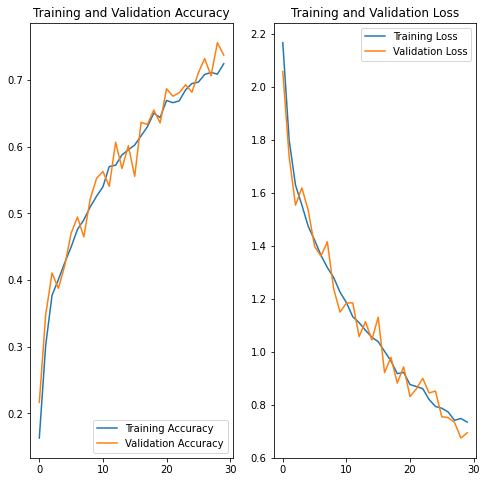

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [49]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 32)       

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
## your code goes here
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 188ms/step - loss: 1.7976 - accuracy: 0.3207 - val_loss: 2.3139 - val_accuracy: 0.1136
Epoch 2/30
169/169 [==============================] - 31s 180ms/step - loss: 1.4871 - accuracy: 0.4293 - val_loss: 2.0890 - val_accuracy: 0.1789
Epoch 3/30
169/169 [==============================] - 31s 179ms/step - loss: 1.3467 - accuracy: 0.4911 - val_loss: 1.6078 - val_accuracy: 0.3898
Epoch 4/30
169/169 [==============================] - 31s 179ms/step - loss: 1.2840 - accuracy: 0.5130 - val_loss: 1.4553 - val_accuracy: 0.4439
Epoch 5/30
169/169 [==============================] - 31s 176ms/step - loss: 1.2211 - accuracy: 0.5328 - val_loss: 1.2317 - val_accuracy: 0.5479
Epoch 6/30
169/169 [==============================] - 31s 181ms/step - loss: 1.1489 - accuracy: 0.5627 - val_loss: 1.2199 - val_accuracy: 0.5538
Epoch 7/30
169/169 [==============================] - 31s 177ms/step - loss: 1.0818 - accuracy: 0.5901 - val_loss: 1.2225 - val_ac

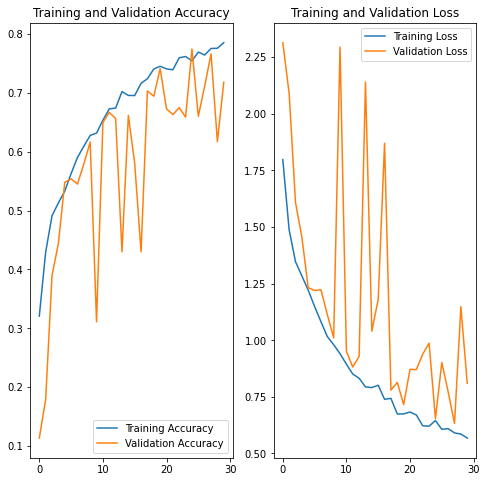

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



the traing loss: 0.7344 and  accuracy: 0.7242 and the calidation val_loss: 0.6942 - val_accuracy: 0.7372 both are almost together with a good accuracy
we were able to get the above results after duing the class rebalance